In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import scipy.stats as stats
import os
import utils
from imp import reload

# Set the plot style
plt.style.use('seaborn-ticks')

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


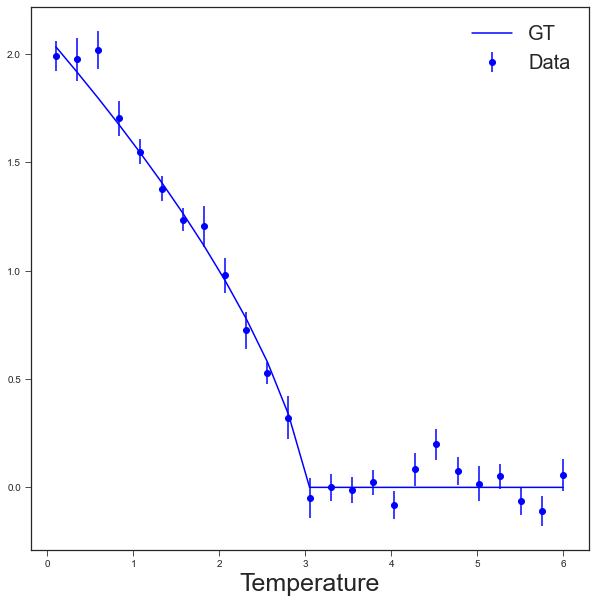

In [2]:
####################################################################################
###### 0) GENERATE ARTIFICIAL DATA
####################################################################################
# Define a ground truth (gt) dictionary
p_gt_dict = {'T_c': 3, 'alpha': 1, 'beta': 2/3}

# Define a power law function
def pow_law(T, p_dict):
    """
    Return power law values for input temperatures 'T' and for a certain set of
    parameters in the dictionary 'p_dict'. The power law is defined as
    y = alpha*(T_c-T)**beta
    
    Args:
        T (1d-array): Array containing the temperature values.
        p_dict (dict: Dictionary containing the power law parameters 'T_c', 'alpha', and 'beta'
            as the dictionary-keys and their values (for the power law) as the dictionary-values.
        
    Returns:
        1d-array of the power law values evaluated at each value of array T.
    """
    # y is zero for all T above T_c thus initialize y as zeros array
    y = np.zeros_like(T)
    
    # Assign the power law to all T below T_c
    inds = np.where(T<=p_dict['T_c'])
    y[inds] = p_dict['alpha']*(p_dict['T_c']-T[inds])**p_dict['beta']
    
    return y

# Generate some artificial data
np.random.seed(42)
T     = np.linspace(0.1, 6, 25)
y_gt  = pow_law(T, p_gt_dict)
y_err = 0.05*np.random.uniform(size=y_gt.shape)+0.05
y     = stats.norm.rvs(loc=y_gt, scale=y_err)
data_dict = {'T': T, 'y': y, 'y_err': y_err}

plt.figure(figsize=(10, 10))
plt.plot(T, y_gt, 'b-', label='GT')
plt.errorbar(T, y, y_err, marker='o', ls='', color='b', label='Data')
plt.legend(fontsize=20)
plt.xlabel('Temperature', fontsize=25)
plt.show()

In [3]:
####################################################################################
###### 1) DEFINE THE MODEL
####################################################################################
# Remark:
# I tried to use the model definition etc. from the tutorial
# https://docs.pymc.io/en/v3/pymc-examples/examples/getting_started.html
# so that you always have the possibility to get more details.

# Define initial values for the parameters (sampling will start there).
# These are not important but they should be reasonable values.
p_dict_init = {'T_c': 3, 'alpha': 1, 'beta': 2/3}

# Define the PyMC model
with pm.Model() as pow_law_model:
    # Define the prior distributions of the model parameters.
    # This is achieved by defining each of the model parameters 
    # as a PyMC3 Random Variable corresponding to its prior.
    # Remarks: 1) This is the part where you as scientist can inject
    #             your expert knowledge about the model parameters.
    #             E.g. if T_c is known from experiments with a value
    #             and standard error (it will usually be implicitly Gaussian)
    #             use a normal distribution with these values for it.
    #             Here I use a rather uninformative prior to stay objective.
    #          2) We can provide an initial value using the keyword 'testval'.
    T_c         = pm.HalfNormal('T_c', sigma=6, testval=p_dict_init['T_c'])
    #T_c         = pm.Normal('T_c', mu=3, sigma=0.1, testval=p_dict_init['T_c'])
    log10_alpha = pm.Normal('log10_alpha', mu=0, sigma=1, testval=np.log10(p_dict_init['alpha']))
    beta        = pm.HalfNormal('beta', sigma=2, testval=p_dict_init['beta'])
    
    # We have defined log10_alpha but would like to work with alpha.
    # There are two possibilities, either simply use
    # alpha = 10**log10_alpha
    # or define it as a 'deterministic' variable so that its samples
    # are tracked and can be accessed (so we don't have to transform
    # all log10_alpha samples ourselfs to alpha samples.)
    # Remark: It is a deterministic variable because if log10_alpha is
    #         set to any (allowed) alpha will be deterministically (without
    #         any uncertainty) be also set.
    alpha = pm.Deterministic('alpha', 10**log10_alpha)
    
    # Use these parameters to define the model function as power law,
    # which itself will also be a PyMC3 random variable of shape (#T,).
    # Remark: pm.math.switch(condition, <case condition True>, <case condition False>)
    y_model  = pm.math.switch(T<=T_c, alpha*(T_c-data_dict['T'])**beta, 0)
    
    # Trick: You can always access the current values of any PyMC3 variable
    #        by using '<variable>.tag.test_value'. This way we can also check
    #        the shape of any variable during debugging.
    #        Remark: Although it is 'testval' in the variable definition above
    #                the attribute is 'test_value'. Maybe there is a reason for this
    #                but I don't know why the developers decided to do this...
    print(f"y_model =\n{y_model.tag.test_value}")
    print(f"y_model.shape = {y_model.tag.test_value.shape}")
    print()
    
    # Define the likelihood
    # Remark: This way of defining the likelihood appeared strange for me when I saw it the
    #         first time. Here the likelihood is defined for each data point as probability
    #         distribution (here Normal because we assume Gaussian Errors) centered at the model
    #         and with uncertainties given by the y-errors.
    #         By providing the data values of y via the keyword 'observed', PyMC3 knows that
    #         these are the data values that will be used when for sampling.
    y_obs = pm.Normal('y_obs', mu=y_model, sigma=data_dict['y_err'], observed=data_dict['y'])
    
    # This likelihood is vectorial and has shape (#T,). Note that mathematically, the likelihood
    # would be the product of all the entries of y_obs.
    print(f"y_obs.shape = {y_obs.tag.test_value.shape}")
    

y_model =
[2.03359906 1.91698535 1.79670895 1.67226106 1.54299455 1.408063
 1.26631935 1.11613518 0.9550465  0.77895996 0.57995783 0.33722861
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
y_model.shape = (25,)

y_obs.shape = (25,)


In [4]:
####################################################################################
###### 2) DETERMINE THE "Maximum A Posteriori" (MAP)
####################################################################################
# As a first step we can determine the Maximum A Posteriori (MAP), which
# is similar to a Maximum Likelihood Estimation but finding the maximum
# of the posterior and not the likelihood.
# Remark: If the prior was uniform, the likelihood and posterior would be the 'same'.
MAP_estimate_dict = pm.find_MAP(model=pow_law_model)

# Let's display the parameter values
print("MAP Parameter Estimates:")
print(f"T_c   = {MAP_estimate_dict['T_c']}")
print(f"alpha = {MAP_estimate_dict['alpha']}")
print(f"beta  = {MAP_estimate_dict['beta']}")
print()

# Remarks:
# 1) The parameter values are automatically set to the MAP values after using 
#    'pm.find_MAP(...)'. This is beneficial for the sampling later as we start
#    in a high density region of the posterior distribution.
# 2) MAP_estimate_dict also contains 'T_c_log__' and 'beta_log__' entries.
#    The reason for this is that PyMC3 transforms bounded distributions to
#    unbounded distributions using a log-transform. The reason for this is
#    that some sampling schemes (e.g. Hamilton Monte Carlo Sampling) only
#    work on unbounded parameter spaces. PyMC3 will work with the log-transformed
#    variables but will also track the original variables (and will later store their 
#    samples during sampling).
print(MAP_estimate_dict)

logp = 29.495, ||grad|| = 4.5351: 100%|██████████| 18/18 [00:00<00:00, 191.89it/s]  


MAP Parameter Estimates:
T_c   = 2.982101548831016
alpha = 0.9959672295079807
beta  = 0.6943901957907237

{'T_c': array(2.98210155), 'log10_alpha': array(-0.00175495), 'beta_log__': array(-0.36472123), 'beta': array(0.6943902), 'alpha': array(0.99596723)}


In [5]:
#################################################################################################
###### 3) SAMPLE THE POSTERIOR OR LOAD THE PARAMETER SAMPLES (IF IT HAS BEEN SAMPLED ALREADY)
#################################################################################################
# Define the number of steps
num_steps  = 15000
tune_steps = 5000 

# Define the path to the trace files (either store sampled values there or load the trace from these files)
trace_path = 'traces/example_trace_narrow_T_c_prior'

# Should load the trace object -- containing the parameter samples -- (if it exists) or sample the posterior to obtain it?
load_trace = False

# Differ cases if we want to sample the posterior or load it.
# Remark: In both cases we end up with a trace object that contains the parameter samples.
if not load_trace:
    # Sample the posterior and save the results in a 'trace object'
    with pow_law_model:
        # Remark: See https://docs.pymc.io/en/v3/api/inference.html for details about the arguments of 'pm.sample'.
        trace = pm.sample(num_steps, random_seed=123, chains=3, init='jitter+adapt_diag', tune=tune_steps, 
                          target_accept=0.9, discard_tuned_samples=False)
    
    print()
    print('Sampling done.')
    print()
    
    # Store the trace in the trace path
    # Remark: Overwrite previous traces if they exist in the trace path
    pm.save_trace(trace, directory=trace_path, overwrite=True)
    print(f"Stored the trace in:\n{trace_path}")

else:
    # Check that the folder exists
    if not os.path.isdir(trace_path):
        err_msg = f"Can not load the trace/posterior-samples.\nThere is no directoy in the provided 'trace_path':\n{trace_path}"
        raise FileNotFoundError(err_msg)
    
    # Load the trace from the trace path
    with pow_law_model:
        trace = pm.load_trace(trace_path)
    
    print(f"Loaded the trace from:\n{trace_path}")
                      

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [beta, log10_alpha, T_c]
Sampling 3 chains, 0 divergences: 100%|██████████| 60000/60000 [11:47<00:00, 84.85draws/s] 
The number of effective samples is smaller than 25% for some parameters.



Sampling done.

Stored the trace in:
traces/example_trace_narrow_T_c_prior


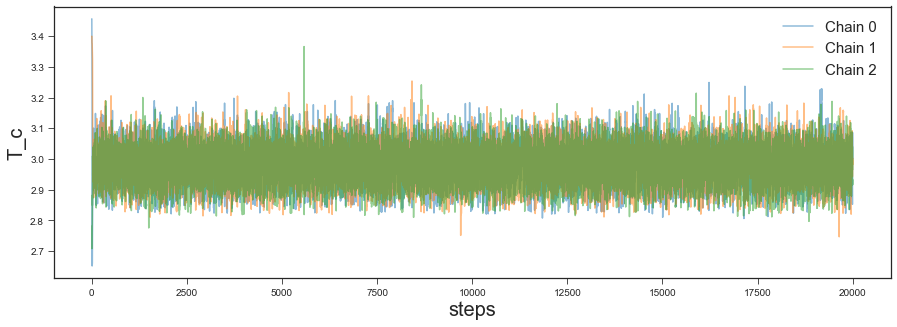

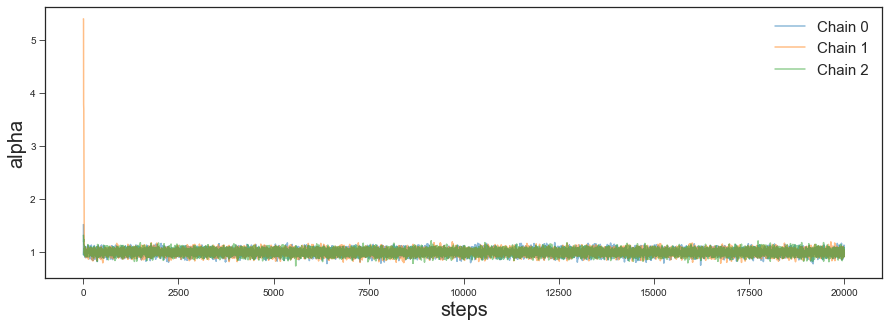

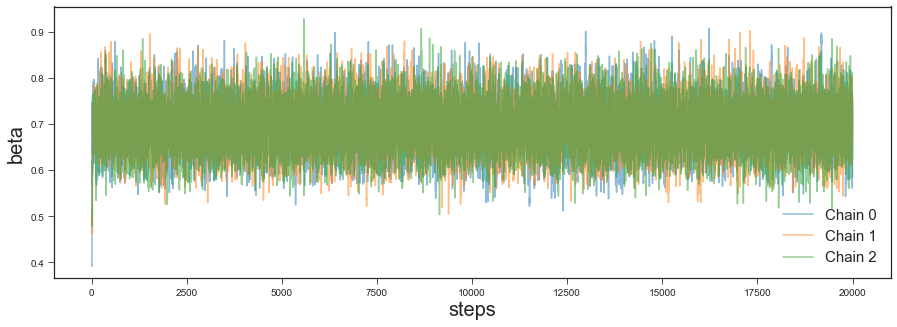

In [6]:
####################################################################################
###### 4) DIAGNOSE SAMPLING TRACES
####################################################################################
reload(utils)

# Remark: The traces of the chains should be checked to assess if the sampling has worked 
#         and also to determine an appropriate number of burnin steps.
utils.plot_trace('T_c', trace)
utils.plot_trace('alpha', trace)
utils.plot_trace('beta', trace)

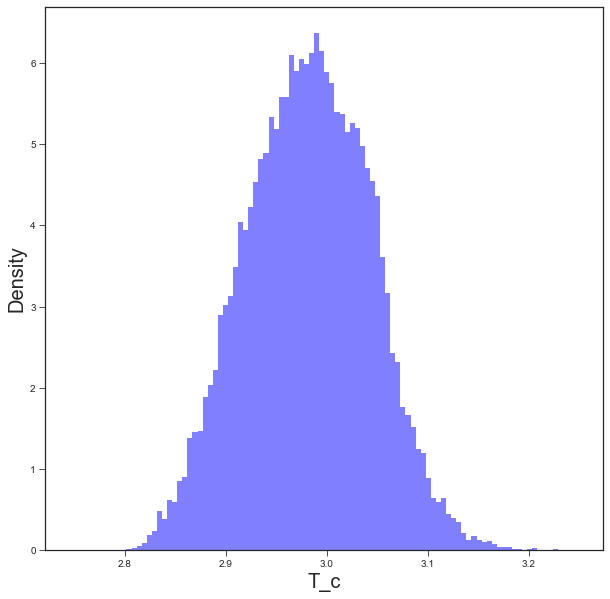

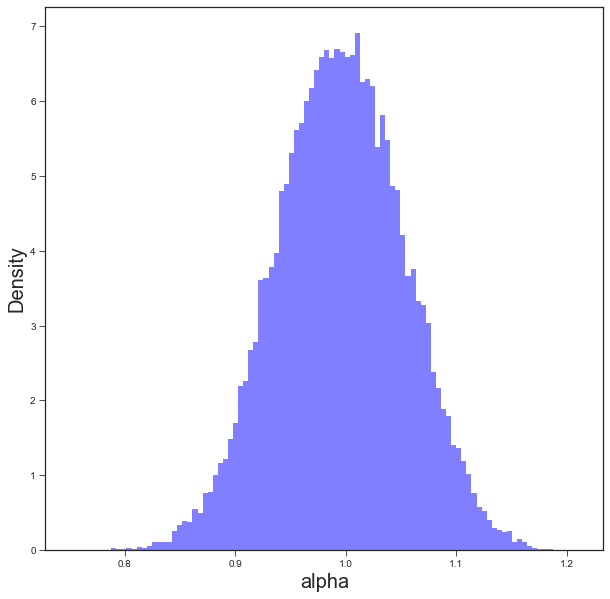

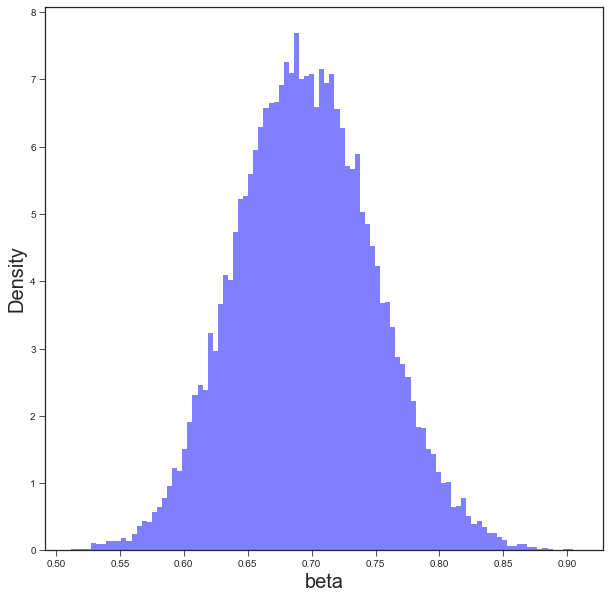

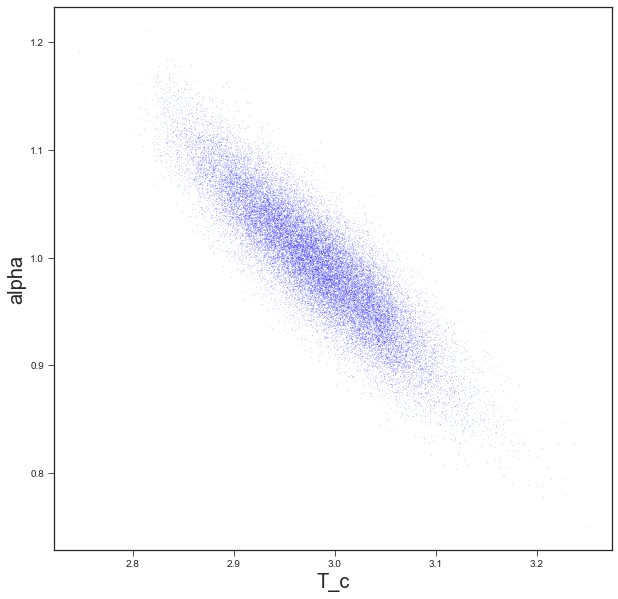

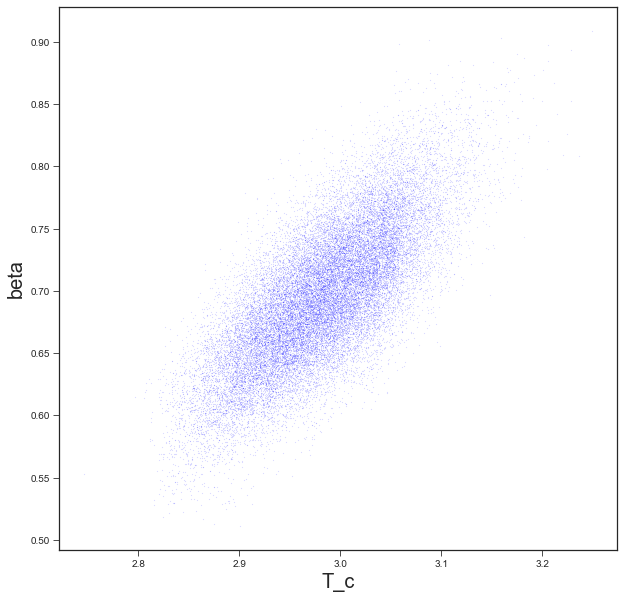

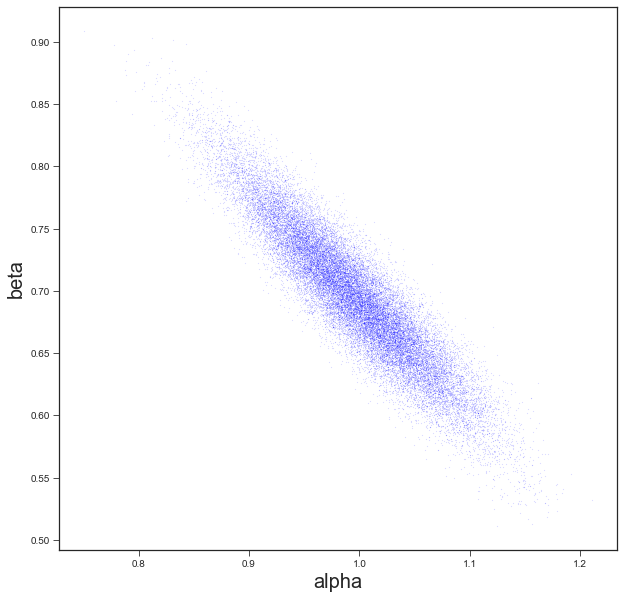

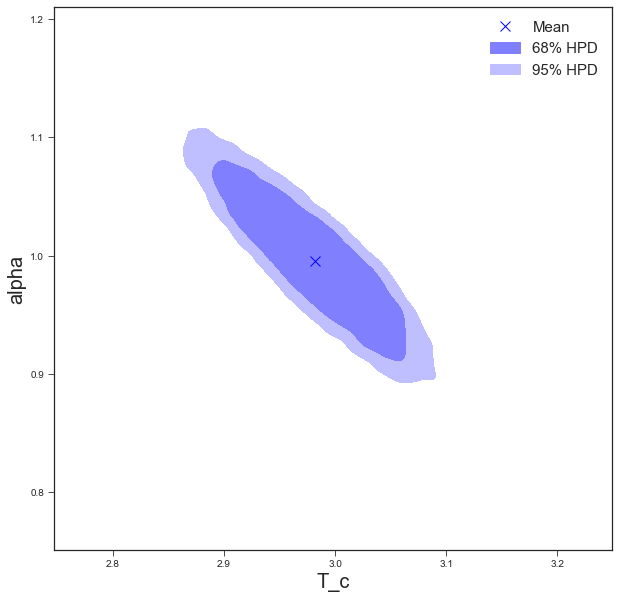

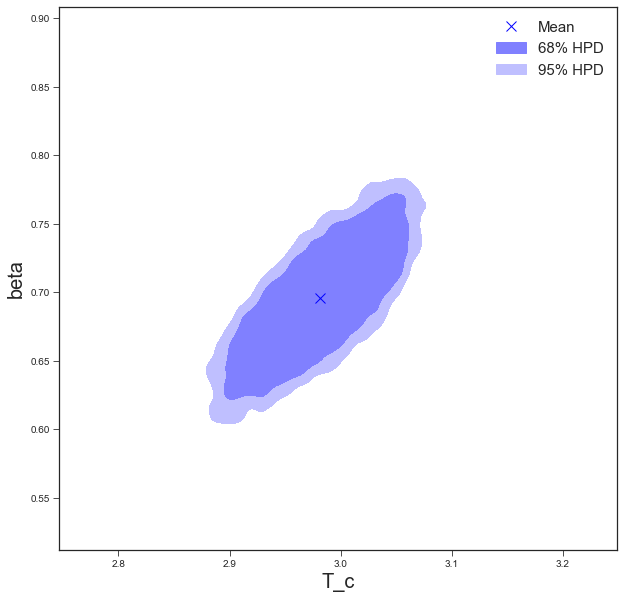

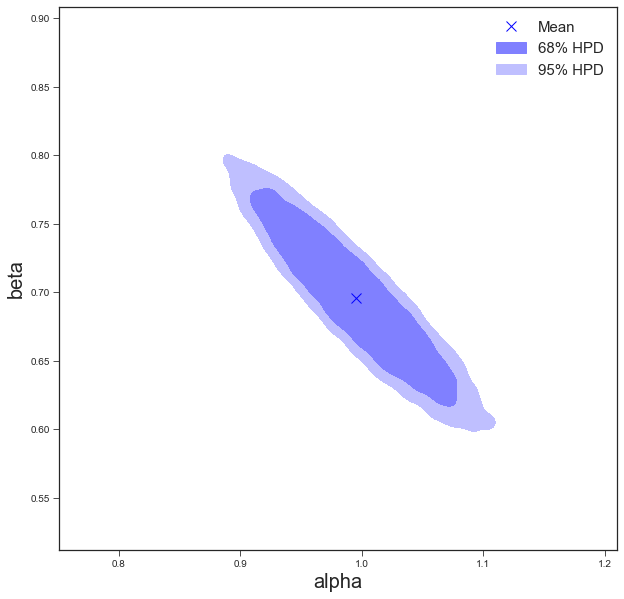

In [7]:
####################################################################################
###### 5) VISUALIZE THE POSTERIOR DISTRIBUTION OF THE PARAMETERS
####################################################################################
reload(utils)

# Plot the marginals
utils.plot_marginal_posterior('T_c', trace, discard=10000)
utils.plot_marginal_posterior('alpha', trace, discard=10000)
utils.plot_marginal_posterior('beta', trace, discard=10000)

# Make pair plots (type scatter)
utils.make_scatter_pair_plot('T_c', 'alpha', trace, color='b', discard=10000)
utils.make_scatter_pair_plot('T_c', 'beta', trace, color='b', discard=10000)
utils.make_scatter_pair_plot('alpha', 'beta', trace, color='b', discard=10000)

# Make pair plots (type contour)
utils.make_contour_pair_plot('T_c', 'alpha', trace, color='b', discard=10000)
utils.make_contour_pair_plot('T_c', 'beta', trace, color='b', discard=10000)
utils.make_contour_pair_plot('alpha', 'beta', trace, color='b', discard=10000)

In [8]:
####################################################################################
###### 6) GET THE PARAMETER ESTIMATES AS SUMMARY STATISTICS
####################################################################################
reload(utils)

# Display the parameter estimates
utils.display_param_estimate('T_c', trace, discard=10000, HPD=68)
utils.display_param_estimate('alpha', trace, discard=10000, HPD=68)
utils.display_param_estimate('beta', trace, discard=10000, HPD=68)

T_c = 2.982+0.068-0.058
alpha = 0.995+0.058-0.057
beta = 0.696+0.053-0.055


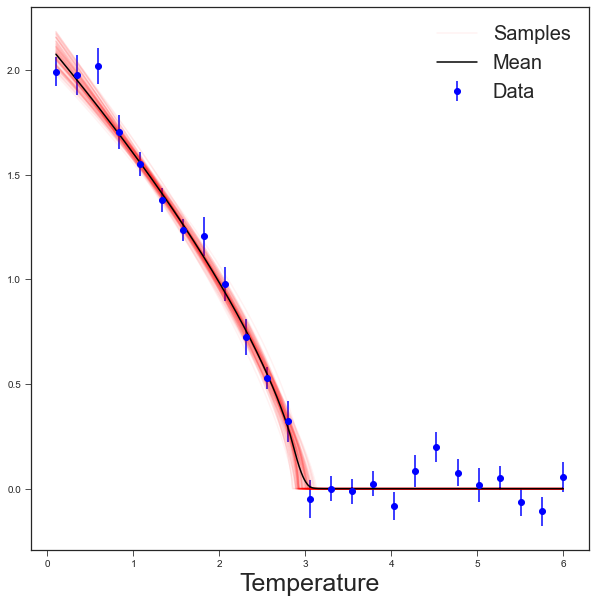

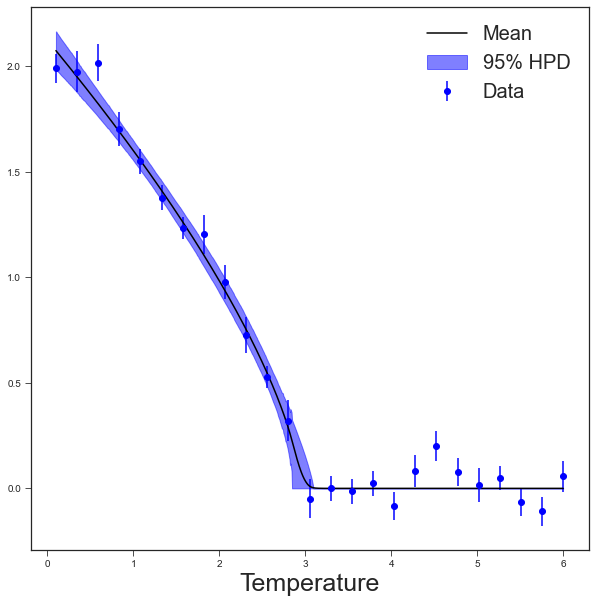

In [14]:
####################################################################################
###### 7) CONSTRUCT THE POSTERIOR DISTRIBUTION OF THE POWER LAW
####################################################################################
reload(utils)

# Construct the power law samples for some temperatures
T = np.linspace(min(data_dict['T']), max(data_dict['T']), 1000)
y_samples = utils.get_pow_law_samples(T, trace, discard=10000)

# Get the mean of the power law samples
# Remark: y_samples is a numpy array of shape (#samples, #T), so
#         we average over the first axis (i.e. over the samples)
mean_y = np.mean(y_samples, axis=0)

###################################################
### FIGURE TYPE 1
###################################################
plt.figure(figsize=(10, 10))
# Display some power law samples
for sample_index, y_sample in enumerate(y_samples[:100]):
    label = None
    if sample_index==0:
        label = 'Samples'
    plt.plot(T, y_sample, 'r-', alpha=0.05, label=label)

# Plot the mean of the power law posterior
plt.plot(T, mean_y, 'k-', label='Mean')

# Plot the data points
plt.errorbar(data_dict['T'], data_dict['y'], data_dict['y_err'], marker='o', ls='', color='b', label='Data')

# Plot settings
plt.legend(fontsize=20)
plt.xlabel('Temperature', fontsize=25)
plt.show()

###################################################
### FIGURE TYPE 2
###################################################
# Get the HPD bounds of the power law posterior using 'get_HDD_bounds_vectorial' for each of the temperature values.
HPD = 95
HPD_bounds_y = utils.get_HDD_bounds_vectorial(y_samples, HDD=HPD)

plt.figure(figsize=(10, 10))
# Display the HPDs as areas
plt.fill_between(T, y1=HPD_bounds_y[0], y2=HPD_bounds_y[1], color='b', alpha=0.5, label=f'{HPD}% HPD')

# Plot the mean of the power law posterior
plt.plot(T, mean_y, 'k-', label='Mean')

# Plot the data points
plt.errorbar(data_dict['T'], data_dict['y'], data_dict['y_err'], marker='o', ls='', color='b', label='Data')

# Plot settings
plt.legend(fontsize=20)
plt.xlabel('Temperature', fontsize=25)
plt.show()


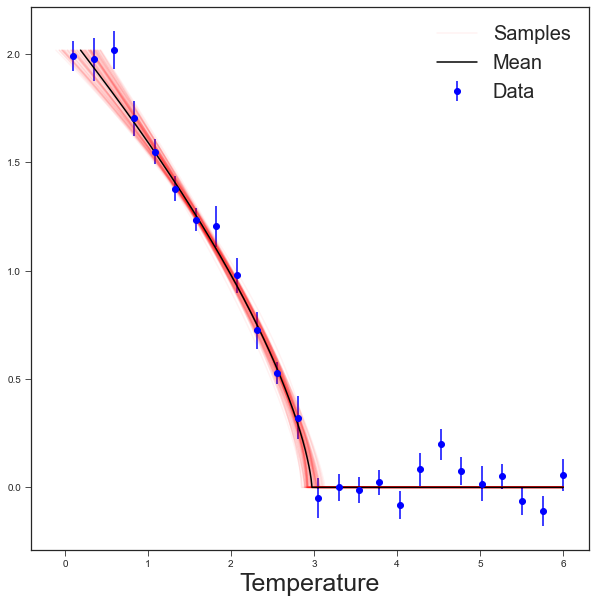

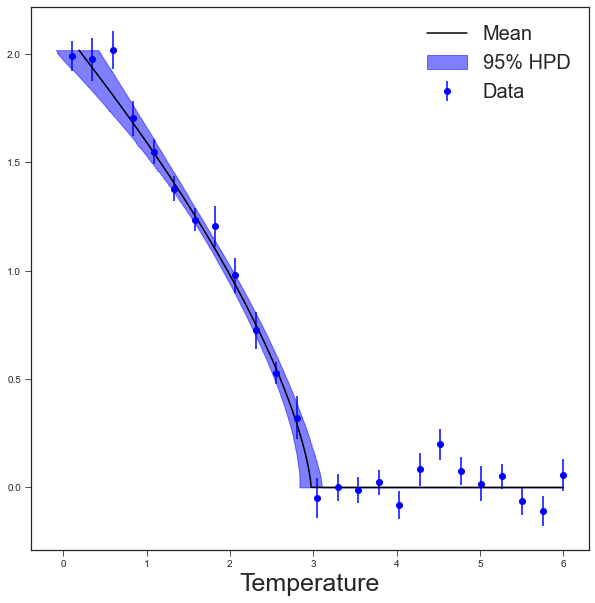

In [15]:
####################################################################################
###### 8) CONSTRUCT THE POSTERIOR DISTRIBUTION OF THE POWER LAW (INVERTED)
####################################################################################
reload(utils)

# Construct the power law samples for some ys
y = np.linspace(0, max(data_dict['y']), 1000)
y, T_samples = utils.get_inverted_pow_law_samples(y, trace, T_max=max(data_dict['T']), discard=10000)

# Get the mean of the T samples
# Remark: T_samples is a numpy array of shape (#samples, #y), so
#         we average over the first axis (i.e. over the samples)
mean_T = np.mean(T_samples, axis=0)

###################################################
### FIGURE TYPE 1
###################################################
plt.figure(figsize=(10, 10))
# Display some power law samples
for sample_index, T_sample in enumerate(T_samples[:100]):
    label = None
    if sample_index==0:
        label = 'Samples'
    plt.plot(T_sample, y, 'r-', alpha=0.05, label=label)

# Plot the mean of the power law posterior
plt.plot(mean_T, y, 'k-', label='Mean')

# Plot the data points
plt.errorbar(data_dict['T'], data_dict['y'], data_dict['y_err'], marker='o', ls='', color='b', label='Data')

# Plot settings
plt.legend(fontsize=20)
plt.xlabel('Temperature', fontsize=25)
plt.show()

###################################################
### FIGURE TYPE 2
###################################################
# Get the HPD bounds of the power law posterior using 'get_HDD_bounds_vectorial' for each of the temperature values.
HPD = 95
HPD_bounds_T = utils.get_HDD_bounds_vectorial(T_samples, HDD=HPD)

plt.figure(figsize=(10, 10))
# Display the HPDs as areas
plt.fill_betweenx(y, x1=HPD_bounds_T[0], x2=HPD_bounds_T[1], color='b', alpha=0.5, label=f'{HPD}% HPD')

# Plot the mean of the power law posterior
plt.plot(mean_T, y, 'k-', label='Mean')

# Plot the data points
plt.errorbar(data_dict['T'], data_dict['y'], data_dict['y_err'], marker='o', ls='', color='b', label='Data')

# Plot settings
plt.legend(fontsize=20)
plt.xlabel('Temperature', fontsize=25)
plt.show()